In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2
import os

In [5]:
binary_images = {}
binary_warped_images = {}
detected_images = {}

In [6]:
images  = glob.glob('camera_cal/calibration*')

nx = 9
ny = 6

objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

objpts = []
imgpts = []

for image in images:
    img = mpimg.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if ret==True:
        objpts.append(objp)
        imgpts.append(corners)
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)


ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, gray.shape[::-1], None, None)
    

In [7]:
for fname in images:
    img = mpimg.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite(os.path.join('output_images', os.path.basename(fname).split('.')[0] + '_undistort.jpg'), dst)

for test_img in glob.glob('test_images/test*'):
    img = mpimg.imread(test_img)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite(os.path.join('output_images', os.path.basename(test_img).split('.')[0] + '_undistort.jpg'), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
                          

In [8]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient=='x':
        x, y = 1, 0
    else:
        x, y = 0, 1
    sobel = cv2.Sobel(gray, cv2.CV_64F, x, y)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sbinary


def mag_thresh(img, sobel_kernel=9, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    gradmag = np.uint8(255*gradmag/np.max(gradmag))
    # Create a binary image of ones where threshold is met, zeros otherwise
    mbinary = np.zeros_like(gradmag)
    mbinary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mbinary

def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    orientation = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(orientation)
    binary_output[(orientation >= thresh[0]) & (orientation <= thresh[1])] = 1
    return binary_output

def color_thresh(img, sthresh=(0,255), vthresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1
    
    binary_output = np.zeros_like(s_channel)
    
    binary_output[(s_binary==1) & (v_binary==1)] = 1
    return binary_output

def draw_polygon(img, pts):
    for p1, p2 in zip(pts, pts[1:]):
        cv2.line(img, tuple(p1), tuple(p2), [255,0,0], 7)
    return img

def hist(img):

    bottom_half = img[img.shape[0]//2:,:]

    histogram = np.sum(bottom_half, axis=0)
    
    return histogram
    
def weighted_img(img, initial_img, α=1.0, β=0.6, γ=1.):
    return cv2.addWeighted(initial_img, α, img, β, γ)   

In [42]:
class ProcessImage:
    def __init__(self, image):
        self.img = image
        self.left_lane_inds = None
        self.right_lane_inds = None
        
        img_size = (self.img[1], self.img[0])
        
        
        self.src = np.float32([[896., 675.],
                      [384., 675.],
                      [581, 460],
                      [699, 460]])
        
        self.dst = np.float32([[896., 720.],
                      [384., 720.],
                      [280., 0.],
                      [1024., 0.]])
        
        self.counter = 0
    
    def all_ok(self):
        if(self.counter > 0):
            return False;
        
        self.counter = 1
        return True;
    
    
    def warp(self, img, src=None, dst=None):
        img_size = (img.shape[1], img.shape[0])
        offset = 120 
        
        if(src==None):
            M = cv2.getPerspectiveTransform(self.src, self.dst)
        else:
            M = cv2.getPerspectiveTransform(src, dst)

        warped = cv2.warpPerspective(img, M, img_size)
        return warped
    
    def unwarp(self, img):
        return self.warp(img, self.dst, self.src)
    
    def apply_thresh(self, img):
        gradx = abs_sobel_thresh(img, 'x', 5, (12, 255))
        grady = abs_sobel_thresh(img, 'y', 5, (25, 255))
        mag_grad = mag_thresh(img, 5, (30, 100))
        dir_grad = dir_thresh(img, 5, thresh=(0.5, 1.3))
        color_binary = color_thresh(img, sthresh=(100, 255), vthresh=(50,255))
        combined = np.zeros_like(color_binary)
        combined[((gradx==1) & (grady==1)) | (color_binary==1)] = 1
        return combined
    
    def undistort(self):
        return cv2.undistort(self.img, mtx, dist, None, mtx)
        
    
    def show(self, img):
        plt.imshow(img, cmap='gray')
    
    
    def find_lane_pixels(self, binary_warped):
        histogram = hist(binary_warped)

        #Create output for visualization

        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        #Setup hyper parameters
        nwindows= 9

        #Set Margin 
        margin = 50

        #Set minpix
        minpix = 50

        window_height = binary_warped.shape[0]//nwindows

        #Identify x and y positions of all the activated pixels

        nonzero =  binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        #Empty lists to receive left and right pixel indices
        left_lane_inds = []
        right_lane_inds = []

        #Set current left and right pixel positions
        leftx_current = leftx_base
        rightx_current = rightx_base

        for window in range(nwindows):
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - (window) * window_height

            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 

            # Identify the nonzero pixels in x and y within the window #
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


            # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        self.left_lane_inds = left_lane_inds
        self.right_lane_inds = right_lane_inds

        return leftx, lefty, rightx, righty, out_img
    
    def fit_poly(self, img_shape, left_fit, right_fit):
        # Generate x and y values for plotting
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
        ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        return left_fitx, right_fitx, ploty
    
    def search_around_poly(self, binary_warped, left_fit, right_fit):
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        # The quiz grader expects 100 here, but feel free to tune on your own!
        margin = 50

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### TO-DO: Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        ### Hint: consider the window areas for the similarly named variables ###
        ### in the previous quiz, but change the windows to our new search area ###
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        self.left_lane_inds = left_lane_inds
        self.right_lane_inds = right_lane_inds
        
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        return left_fit, right_fit

        

    def fit_polynomial(self, binary_warped):
        # Find our lane pixels first
        leftx, lefty, rightx, righty, out_img = self.find_lane_pixels(binary_warped)

        # Fit a second order polynomial to each using `np.polyfit`
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except TypeError:
            # Avoids an error if `left_fit` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty

        ## Visualization ##
        # Colors in the left and right lane regions 
        # out_img[lefty, leftx] = [0, 255, 0]
        # out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        # plt.plot(left_fitx, ploty, color='yellow')
        # plt.plot(right_fitx, ploty, color='yellow')

        # return out_img
        return left_fit, right_fit
   
    def execute(self):
        #undistort 
        dst = self.undistort()
        combined = self.apply_thresh(dst)
        combined_warped = self.warp(combined)
        # output = self.fit_polynomial(combined_warped)
        return combined_warped
    
    def draw_lanes(self, binary_warped, left_fit, right_fit):
        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        
        left_lane_inds = self.left_lane_inds
        right_lane_inds = self.right_lane_inds
        
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        left_fitx, right_fitx, ploty = self.fit_poly(binary_warped.shape, left_fit, right_fit)
        margin = 50
        
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        
        lane_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        lane_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                                  ploty])))])
        lane_pts = np.hstack((lane_window1, lane_window2))
        

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([lane_pts]), (0,0, 255))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        # plt.plot(left_fitx, ploty, color='yellow')
        # plt.plot(right_fitx, ploty, color='yellow')
        ## End visualization steps ##
    
        return result
    
    def measure_curvature(self, left_fit, right_fit):
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
        ploty = np.linspace(0, 719, num=720)
        
        left_fit_cr = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fit_cr = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Start by generating our fake example data
        # Make sure to feed in your real data instead in your project

        # Define y-value where we want radius of curvature
        # We'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(ploty)

        # Calculation of R_curve (radius of curvature)
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        return left_curverad, right_curverad

    
    def add_text(self, img, l_curv, r_curv):
        # font
        font = cv2.FONT_HERSHEY_SIMPLEX

        # org
        org = (200, 200)

        # fontScale
        fontScale = 1

        # Blue color in BGR
        color = (255, 0, 0)
        
        text = 'R_Curve: {}'.format(r_curve)
        text += '\n'
        text += 'L_Curve: {}'.format(l_curve)

        # Line thickness of 2 px
        thickness = 5
        
        image = cv2.putText(image, text, org, font, 
                   fontScale, color, thickness, cv2.LINE_AA)
        
        return image
    
    def get_center(self, binary_warped, leftx, rightx, xm_per_pix):
        camera_center = (leftx[-1] + rightx[-1])/2
        center_diff = (camera_center - binary_warped.shape[1]/2) * xm_per_pix
        return center_diff
        
        

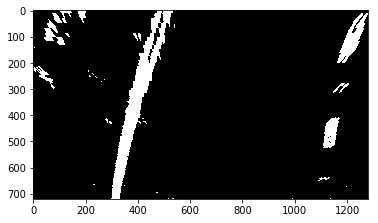

In [43]:
img = mpimg.imread('test_images/test6.jpg')
Img = ProcessImage(img)
thresh = Img.apply_thresh(img)
warped = Img.warp(thresh)
plt.imshow(warped, cmap='gray')

In [55]:
def process_image(img):
    Img = ProcessImage(img)
    combined_warped = Img.execute()
    
    
#     if(Img.all_ok()):
#         left_fit, right_fit = Img.fit_polynomial(combined_warped)
#     else:
#         left_fit, right_fit = Img.search_around_poly(combined_warped, left_fit, right_fit)
    left_fit, right_fit = Img.fit_polynomial(combined_warped) 
    result = Img.draw_lanes(combined_warped, left_fit, right_fit)
    
    leftx, rightx, ploty = Img.fit_poly(combined_warped.shape, left_fit, right_fit)
    
     # Define conversions in x and y from pixels space to meters
    ym_per_pix = 10/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    
    
    #Unwarp the result
    unwarped = Img.unwarp(result)
    

    # font
    font = cv2.FONT_HERSHEY_SIMPLEX

    # org
    org = (50, 50)

    # fontScale
    fontScale = 2

    # Blue color in BGR
    color = (255, 0, 0)

    # Line thickness of 2 px
    thickness = 2

    # Using cv2.putText() method
    for i in range(2):
        if(i==0):
            cv2.putText(unwarped, 'Left CR = {} m'.format(round(left_curverad)), org, font, 
                           fontScale, color, thickness, cv2.LINE_AA)
        else:
            cv2.putText(unwarped, 'Right CR = {} m'.format(round(right_curverad)), (50, 100),
                       font, fontScale, color, thickness, cv2.LINE_AA)
    
    offset = Img.get_center(combined_warped, leftx, rightx, xm_per_pix)
    
    cv2.putText(unwarped, 'Offset from Center = {:.3f} m,'.format(offset), (50, 150),
                       font, fontScale, color, thickness, cv2.LINE_AA)
    
    
    #Create weighted image
    weighted = weighted_img(unwarped, img)
    
    return weighted
    
    

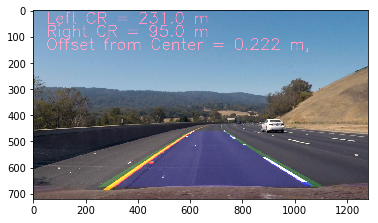

In [56]:
img = mpimg.imread('test_images/test3.jpg')
result = process_image(img)
plt.imshow(result)
# cv2.imwrite('output_images/lane_drawn_final.jpg', cv2.cvtColor(result, cv2.COLOR_RGB2BGR))

In [54]:
# img = mpimg.imread('test_images/test6.jpg')
# process(img)
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [07:29<00:00,  2.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 4min 28s, sys: 50.8 s, total: 5min 19s
Wall time: 7min 32s


In [51]:
test_images = glob.glob('test_images/test*')

for fname in test_images:
    img = mpimg.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    # plt.imshow(dst)
    gradx = abs_sobel_thresh(img, 'x', 5, (30, 100))
    grady = abs_sobel_thresh(img, 'y', 5, (30, 100))
    mag_grad = mag_thresh(img, 5, (30, 100))
    dir_grad = dir_thresh(img, 5, thresh=(0.5, 1.3))
    color_binary = color_thresh(img, (180, 255))
    
    combined = np.zeros_like(color_binary)
    combined[((gradx==1) & (grady==1)) | ((mag_grad==1) & (dir_grad==1)) | (color_binary==1)] = 1
    output_name = os.path.basename(fname).split('.')[0] + '_unthresh.jpg'
    binary_images[output_name] = combined
    # plt.imshow(combined, cmap='gray')
    cv2.imwrite(os.path.join('output_images', output_name), combined*255)

In [34]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    offset = 120
    
    src = np.float32([[200, 700], 
                     [580, 450], 
                     [700, 450], 
                     [1100, 700]])
    
    dst = np.float32([[370, img.shape[0]], 
                     [370, 0], 
                     [950, 0], 
                     [950, img.shape[0]]])
    
    
    
    M = cv2.getPerspectiveTransform(src, dst)
    
    warped = cv2.warpPerspective(img, M, img_size)
    return warped

In [35]:
test_images = glob.glob('output_images/test[1-9]_unthresh.*')
test_images_straight = glob.glob('test_images/straight_lines*')

src = np.float32([[200, 700], 
                 [580, 450], 
                 [700, 450], 
                 [1100, 700]])

    
dst = np.float32([[370, img.shape[0]], 
                  [370, 0], 
                  [950, 0], 
                  [950, img.shape[0]]])

def draw(img, pts):
    for point1, point2 in zip(pts, pts[1:]):
        cv2.line(img, tuple(point1), tuple(point2), [255,0,0], 2)
    return img

for fname in test_images_straight:
    img = mpimg.imread(fname)
    img = draw(img, src)
    cv2.imwrite(os.path.join('output_images', os.path.basename(fname).split('.')[0] + '_drawn.jpg'), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

for output_name, img in binary_images.items():
    binary_warped = warp(img)
    warped_output_name = output_name.split('.')[0] + '_warped.jpg'
    binary_warped_images[warped_output_name] = binary_warped
    cv2.imwrite(os.path.join('output_images', warped_output_name), binary_warped*255)
    


In [43]:
def find_lane_pixels(binary_warped):
    histogram = hist(binary_warped)
    
    #Create output for visualization
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    #Setup hyper parameters
    nwindows= 9
    
    #Set Margin 
    margin = 100
    
    #Set minpix
    minpix = 50
    
    window_height = binary_warped.shape[0]//nwindows
    
    #Identify x and y positions of all the activated pixels
    
    nonzero =  binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #Empty lists to receive left and right pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    #Set current left and right pixel positions
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - (window) * window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
        
        # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img
        

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left_fit` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [0, 255, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    # plt.plot(left_fitx, ploty, color='yellow')
    # plt.plot(right_fitx, ploty, color='yellow')

    return out_img
   
    

In [44]:

for output_name, img in binary_warped_images.items():
    result = fit_polynomial(img)
    fit_output_name = output_name.split('.')[0] + '_lanesdetected.jpg'
    detected_images[fit_output_name] = result
    cv2.imwrite(os.path.join('output_images', fit_output_name), result)